**Evaluation of Ichnos - Full Workshop Paper**

In [344]:
# Imports (for Graphs + Analysis)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tabulate import tabulate
import sklearn
from sklearn.metrics import root_mean_squared_error

sns.set_theme(style='ticks', context='paper')

In [345]:
# Read Data from TS File
def read_ts(filename):
    ts_data = {}

    with open(filename, 'r') as f:
        data = f.readlines()

    for load, row_i in zip(range(0, 100, 10), range(1,12)):
        ts_data[load] = float(data[row_i].strip().split(',')[3])

    ts_data[100] = float(data[14].strip().split(',')[3])  # power consumption with maximize stress test

    return ts_data 


def get_average_ts(node, freq):
    paths = [f'data/tasks/{node}/stats/ts-{freq}-{iteration}.csv' for iteration in range(1, 4)]

    readings = {}

    for path in paths:
        path_data = read_ts(path)

        for load,val in path_data.items():
            if load in readings:
                readings[load].append(val)
            else:
                readings[load] = [val]

    data = {}

    for load,vals in readings.items():
        data[load] = sum(vals) / 3

    return data

def get_average_ts_files(path):
    paths = [path.replace('ITER', str(iteration)) for iteration in range(1, 4)]
    readings = {}

    for path in paths:
        path_data = read_ts(path)

        for load,val in path_data.items():
            if load in readings:
                readings[load].append(val)
            else:
                readings[load] = [val]

    data = {}

    for load,vals in readings.items():
        data[load] = sum(vals) / 3

    return data

In [346]:
# Utilities
def get_linear_predictions(min, max):
    print(f'min: {min} | max: {max}')
    return [(min + (usage / 100) * (max - min)) for usage in range(0, 110, 10)]

MODELS = []

In [347]:
class Polynomial:
    def __init__(self, coefficients):
        self.coeffs = coefficients

    def __str__(self):
        chunks = []
        for coeff, power in zip(self.coeffs, range(len(self.coeffs), -1, -1)):
            if coeff == 0:
                continue
            chunks.append('(')
            chunks.append(self.format_coeff(coeff))
            chunks.append(self.format_power(power))
            chunks.append(') +')
        return ' '.join(chunks)

    @staticmethod
    def format_coeff(coeff):
        return str(coeff) if coeff < 0 else "{0}".format(coeff)

    @staticmethod
    def format_power(power):
        return ' * (x ** {0})'.format(power) if power != 0 else ''

In [348]:
# Helper Functions
def plot_ts_report(node, govs):
    ts_paths = [f'data/{node}/ts/ts-{gov}-ITER.csv' for gov in govs]
    node_stats = {}

    for ts_path, gov in zip(ts_paths, govs):
        plt.figure(figsize=(6,3))

        node_stats[f"{node}:{gov}"] = get_average_ts_files(ts_path)
        x = range(0,110,10)
        y = node_stats[f"{node}:{gov}"].values()
        y_arr = list(y)
        coefficients = np.polyfit(x, y_arr, 3)
        p = np.poly1d(coefficients)
        xp = np.linspace(0, 100)

        print(f'Node {node} w/ Governor {gov} -- Model Accuracy')
        linear_pred = get_linear_predictions(y_arr[0], y_arr[-1])
        linear_rmse = root_mean_squared_error(y_arr, linear_pred)
        print(f'RMSE of Linear Model: {linear_rmse}')
        print(p)
        model = Polynomial(p)
        print(f'Model: {model}')
        MODELS.append(f'{node}:{gov}={model}')

        y_pred = [p(x_val) for x_val in x]
        rmse = root_mean_squared_error(y_arr, y_pred)
        print(f'RMSE of Model: {rmse}')

        plt.scatter(x, y, label=f"{node}:{gov}", marker='x')
        plt.plot(xp, p(xp), label='cubic fit', color='green')
        plt.plot(x, linear_pred, label='linear', color='red')
        
        plt.ylim(0,max(y)+10)
        plt.xticks(range(0,110,10))
        plt.legend(loc='lower right')
        plt.title(f'Node {node} w/ Governor {gov}')

        plt.show()

Node gpgnode-13 w/ Governor ondemand -- Model Accuracy
min: 48.26 | max: 124.96333333333332
RMSE of Linear Model: 12.963803425014767
          3           2
2.12e-05 x - 0.01031 x + 1.583 x + 49
Model: ( 2.120111370111352e-05  * (x ** 3) ) + ( -0.010314627039627027  * (x ** 2) ) + ( 1.583392126392127  * (x ** 1) ) + ( 49.00097902097905  ) +
RMSE of Model: 0.5905366018614144


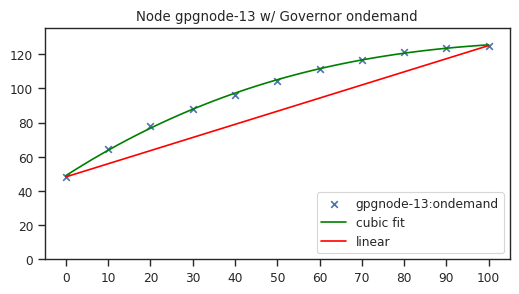

Node gpgnode-13 w/ Governor performance -- Model Accuracy
min: 49.056666666666665 | max: 124.95333333333333
RMSE of Linear Model: 12.141152394424777
           3           2
2.862e-05 x - 0.01077 x + 1.544 x + 50.28
Model: ( 2.861564361564371e-05  * (x ** 3) ) + ( -0.010774902874902908  * (x ** 2) ) + ( 1.5437219632219659  * (x ** 1) ) + ( 50.27918414918414  ) +
RMSE of Model: 0.8371410443916413


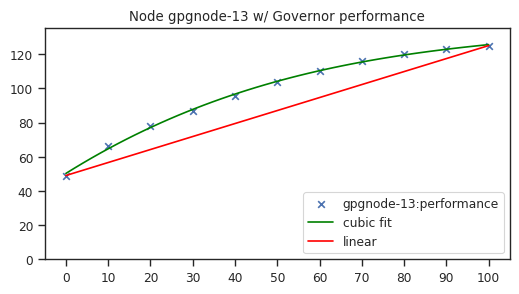

Node gpgnode-13 w/ Governor powersave -- Model Accuracy
min: 48.166666666666664 | max: 104.88666666666666
RMSE of Linear Model: 7.946516039857798
            3            2
-1.251e-06 x - 0.004353 x + 1.018 x + 48.06
Model: ( -1.2509712509706113e-06  * (x ** 3) ) + ( -0.00435291375291386  * (x ** 2) ) + ( 1.0180155400155448  * (x ** 1) ) + ( 48.060862470862425  ) +
RMSE of Model: 0.22019884802003745


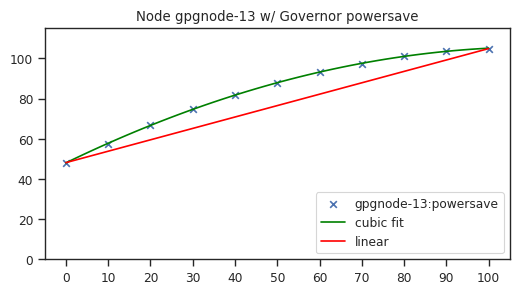

In [349]:
# Graph the Power Consumption for gpgnode-13
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-13', governors)

Node gpgnode-14 w/ Governor ondemand -- Model Accuracy
min: 49.833333333333336 | max: 125.08
RMSE of Linear Model: 12.20992542106128
           3           2
2.544e-05 x - 0.01051 x + 1.547 x + 50.54
Model: ( 2.5435120435119894e-05  * (x ** 3) ) + ( -0.01050792540792533  * (x ** 2) ) + ( 1.546503108003105  * (x ** 1) ) + ( 50.543682983683055  ) +
RMSE of Model: 0.6120792988027645


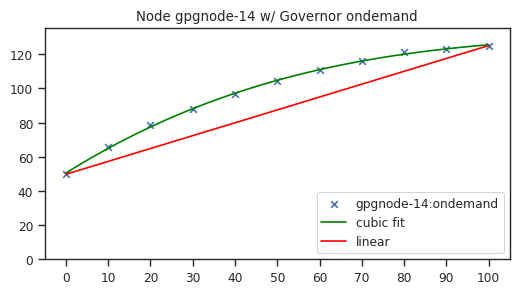

Node gpgnode-14 w/ Governor performance -- Model Accuracy
min: 50.56666666666666 | max: 125.25
RMSE of Linear Model: 11.552112590475836
           3           2
2.977e-05 x - 0.01055 x + 1.501 x + 51.75
Model: ( 2.976560476560505e-05  * (x ** 3) ) + ( -0.01055419580419587  * (x ** 2) ) + ( 1.500831131831135  * (x ** 1) ) + ( 51.75289044289049  ) +
RMSE of Model: 0.8599092931066993


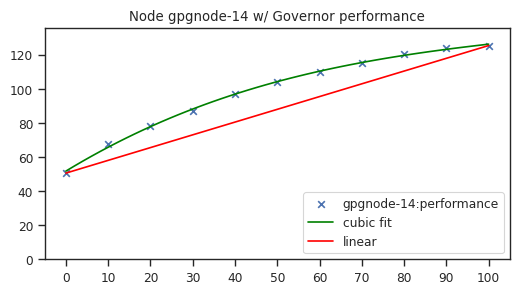

Node gpgnode-14 w/ Governor powersave -- Model Accuracy
min: 49.413333333333334 | max: 105.60666666666667
RMSE of Linear Model: 7.454049838168443
            3            2
-1.612e-06 x - 0.004016 x + 0.9829 x + 49.29
Model: ( -1.612276612276791e-06  * (x ** 3) ) + ( -0.004015695415695406  * (x ** 2) ) + ( 0.9829405594405596  * (x ** 1) ) + ( 49.289160839160864  ) +
RMSE of Model: 0.2915081891173531


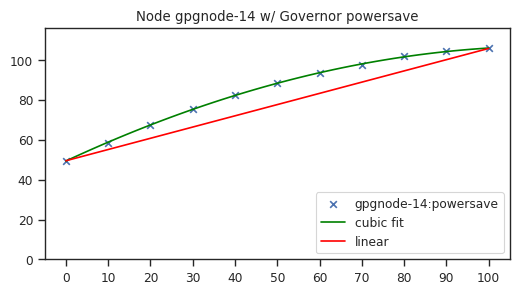

In [350]:
# Graph the Power Consumption for gpgnode-14
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-14', governors)

Node gpgnode-15 w/ Governor ondemand -- Model Accuracy
min: 53.53333333333333 | max: 139.12
RMSE of Linear Model: 12.963841127060945
           3            2
1.018e-05 x - 0.008689 x + 1.625 x + 53.97
Model: ( 1.0183890183890104e-05  * (x ** 3) ) + ( -0.008689432789432792  * (x ** 2) ) + ( 1.625279202279203  * (x ** 1) ) + ( 53.970606060606066  ) +
RMSE of Model: 0.6185222221970276


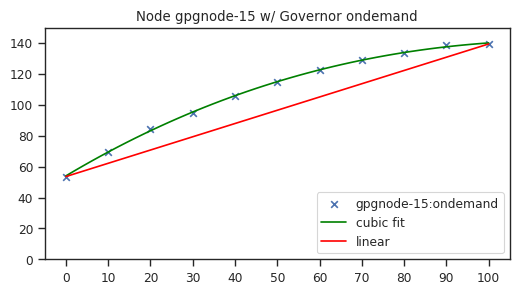

Node gpgnode-15 w/ Governor performance -- Model Accuracy
min: 54.88666666666666 | max: 138.81666666666666
RMSE of Linear Model: 12.009487009540555
           3            2
1.108e-05 x - 0.008065 x + 1.537 x + 55.73
Model: ( 1.10839160839165e-05  * (x ** 3) ) + ( -0.008064724164724252  * (x ** 2) ) + ( 1.5371985236985277  * (x ** 1) ) + ( 55.72610722610721  ) +
RMSE of Model: 0.853678681133499


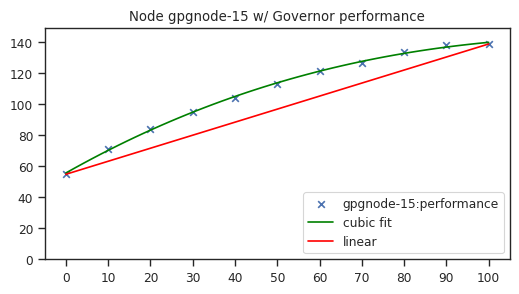

Node gpgnode-15 w/ Governor powersave -- Model Accuracy
min: 52.949999999999996 | max: 120.30333333333334
RMSE of Linear Model: 8.815726225835785
           3            2
-3.16e-06 x - 0.004508 x + 1.161 x + 52.84
Model: ( -3.1598031598030393e-06  * (x ** 3) ) + ( -0.004507808857808884  * (x ** 2) ) + ( 1.161149313649315  * (x ** 1) ) + ( 52.835780885780885  ) +
RMSE of Model: 0.47731927844907446


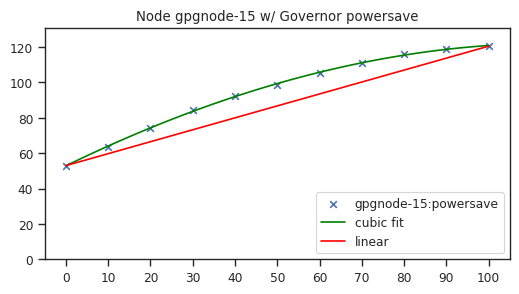

In [351]:
# Graph the Power Consumption for gpgnode-15
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-15', governors)

Node gpgnode-16 w/ Governor ondemand -- Model Accuracy
min: 46.21666666666667 | max: 111.82333333333334
RMSE of Linear Model: 10.33129852888441
           3           2
2.117e-05 x - 0.00894 x + 1.339 x + 46.5
Model: ( 2.1170681170680637e-05  * (x ** 3) ) + ( -0.008939510489510433  * (x ** 2) ) + ( 1.3387931882931874  * (x ** 1) ) + ( 46.50426573426577  ) +
RMSE of Model: 0.3381183780550558


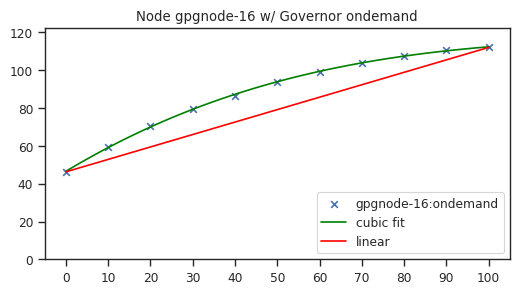

Node gpgnode-16 w/ Governor performance -- Model Accuracy
min: 46.53 | max: 111.57
RMSE of Linear Model: 10.097307291820655
           3            2
2.297e-05 x - 0.008907 x + 1.309 x + 47.26
Model: ( 2.2970085470085892e-05  * (x ** 3) ) + ( -0.00890654623154631  * (x ** 2) ) + ( 1.3093255633255667  * (x ** 1) ) + ( 47.258648018648  ) +
RMSE of Model: 0.5307623440987613


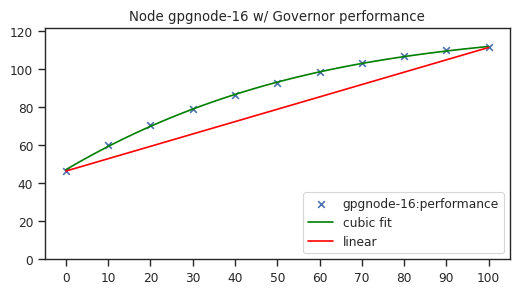

Node gpgnode-16 w/ Governor powersave -- Model Accuracy
min: 45.699999999999996 | max: 96.99333333333334
RMSE of Linear Model: 6.936732077800895
           3            2
3.111e-06 x - 0.004414 x + 0.9267 x + 45.58
Model: ( 3.1112406112409483e-06  * (x ** 3) ) + ( -0.00441396658896663  * (x ** 2) ) + ( 0.9267213157213164  * (x ** 1) ) + ( 45.58177156177157  ) +
RMSE of Model: 0.47221389328215035


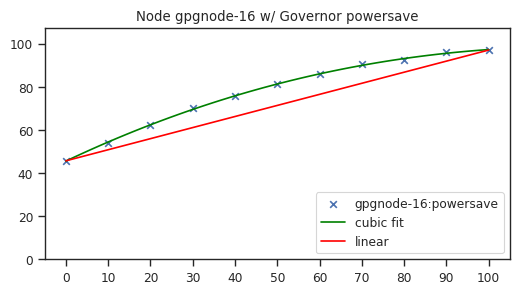

In [352]:
# Graph the Power Consumption for gpgnode-16
governors = ['ondemand', 'performance', 'powersave']
plot_ts_report('gpgnode-16', governors)

Node gpgnode-22 w/ Governor performance -- Model Accuracy
min: 117.37 | max: 345.76666666666665
RMSE of Linear Model: 56.45178873663488
           3          2
0.0007415 x - 0.1346 x + 8.233 x + 131.4
Model: ( 0.0007414795389795361  * (x ** 3) ) + ( -0.13460499222999192  * (x ** 2) ) + ( 8.232617586117582  * (x ** 1) ) + ( 131.4333566433568  ) +
RMSE of Model: 9.608163382866831


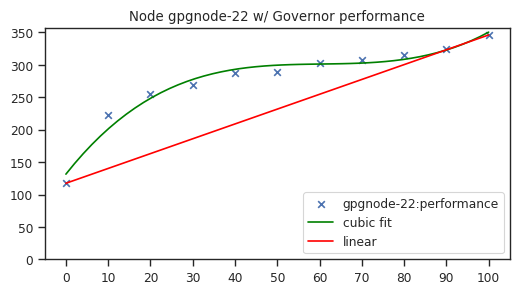

Node gpgnode-22 w/ Governor powersave -- Model Accuracy
min: 94.77333333333333 | max: 347.1433333333334
RMSE of Linear Model: 63.10049556105327
           3          2
0.0008558 x - 0.1542 x + 9.282 x + 110.5
Model: ( 0.0008557536907536887  * (x ** 3) ) + ( -0.15424075369075355  * (x ** 2) ) + ( 9.282093240093246  * (x ** 1) ) + ( 110.46752913752906  ) +
RMSE of Model: 10.598511556950378


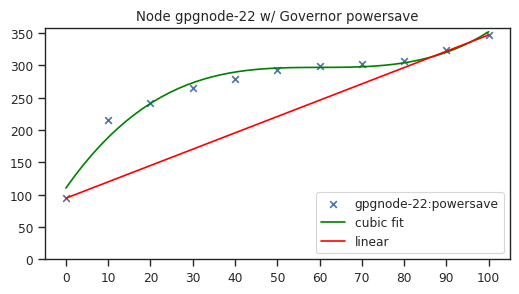

In [353]:
# Graph the Power Consumption for gpgnode-22
governors = ['performance', 'powersave']
plot_ts_report('gpgnode-22', governors)

**Observations**
- performance follows a similar pattern to ondemand on all the old GPG nodes, where there is a gap between that and power consumed using powersave
- node 15 (old GPG node) has a higher peak power consumption compared to the others, maybe less utilised, shows that not all devices will age the same
- more recent node, node 22 has close readings when comparing performance to powersave
- the RMSE of the cubic fit improves on the linear, which is what Ichnos would default to, and what Green Algorithms and similar approaches use
- theoretically, taking these measurements and then running the script should allow for the use of a cubic model when estimating the footprint

In [354]:
print('Models')

for model in MODELS:
    parts = model.split('=')
    func = parts[1].replace('x', 'cpu_usage')[:-2]
    print(parts[0])
    print(func)

Models
gpgnode-13:ondemand
( 2.120111370111352e-05  * (cpu_usage ** 3) ) + ( -0.010314627039627027  * (cpu_usage ** 2) ) + ( 1.583392126392127  * (cpu_usage ** 1) ) + ( 49.00097902097905  )
gpgnode-13:performance
( 2.861564361564371e-05  * (cpu_usage ** 3) ) + ( -0.010774902874902908  * (cpu_usage ** 2) ) + ( 1.5437219632219659  * (cpu_usage ** 1) ) + ( 50.27918414918414  )
gpgnode-13:powersave
( -1.2509712509706113e-06  * (cpu_usage ** 3) ) + ( -0.00435291375291386  * (cpu_usage ** 2) ) + ( 1.0180155400155448  * (cpu_usage ** 1) ) + ( 48.060862470862425  )
gpgnode-14:ondemand
( 2.5435120435119894e-05  * (cpu_usage ** 3) ) + ( -0.01050792540792533  * (cpu_usage ** 2) ) + ( 1.546503108003105  * (cpu_usage ** 1) ) + ( 50.543682983683055  )
gpgnode-14:performance
( 2.976560476560505e-05  * (cpu_usage ** 3) ) + ( -0.01055419580419587  * (cpu_usage ** 2) ) + ( 1.500831131831135  * (cpu_usage ** 1) ) + ( 51.75289044289049  )
gpgnode-14:powersave
( -1.612276612276791e-06  * (cpu_usage ** 3) )

In [ ]:
# what is polynomial fitting: regression analysis
# aim of modelling relationship between independent variable x (cpu utilisation), 
# and dependent variable y (the power consumption) as an n-degree polynomial
# goal to find the polynomial coefficients that minimise diff. between actual data & values predicted

In [ ]:
# Calculate the Energy from each Workflow Execution
def parse_perf_log(filename):
    with open(filename) as f:
        lines = f.readlines()
        data = []

        for line in lines:
            if line.strip():
                data.append(line.strip())

    vals = {}
    vals['start'] = ' '.join(data[0].split(' ')[3:])
    vals['pkg'] = float(data[3].split(' ')[0].replace(',', ''))
    vals['ram'] = float(data[4].split(' ')[0].replace(',', ''))
    vals['time'] = float(data[5].split(' ')[0].replace(',', ''))

    return vals

def joules_to_kwh(joules):
    return round(joules / 3600000, 2)

{'start': 'Wed Feb  5 09:33:50 2025', 'pkg': 461751.24, 'ram': 112879.09, 'time': 6849.213473705}
pkg 0.13kWh
ram 0.03kWh


In [362]:
# GPG Node 13 - ondemand
data = parse_perf_log('data/gpgnode-13/ondemand/perf-1.txt')

print('perf readings')
print(data)
print(f'pkg {joules_to_kwh(data['pkg'])}kWh')
print(f'ram {joules_to_kwh(data['ram'])}kWh')

print('new model')
wf_gpg_13_ondemand_core = 0.09718910817494845
wf_gpg_13_ondemand_mem = 0.01188718636
print(f'core {round(wf_gpg_13_ondemand_core, 2)}kWh')
print(f'mem {round(wf_gpg_13_ondemand_mem, 2)}kWh')

# green algorithms
print('green algorithms')
wf_gpg_13_baseline_core = 0.07092624250694445
wf_gpg_13_baseline_mem = 0.01188718636
print(f'core {round(wf_gpg_13_baseline_core, 2)}kWh')
print(f'mem {round(wf_gpg_13_baseline_mem, 2)}kWh')

# linear
print('linear')
wf_gpg_13_linear_core = 0.17696431687502232
wf_gpg_13_linear_mem = 0.01188718636
print(f'core {round(wf_gpg_13_linear_core, 2)}kWh')
print(f'mem {round(wf_gpg_13_linear_mem, 2)}kWh')

perf readings
{'start': 'Wed Feb  5 09:33:50 2025', 'pkg': 461751.24, 'ram': 112879.09, 'time': 6849.213473705}
pkg 0.13kWh
ram 0.03kWh
new model
core 0.1kWh
mem 0.01kWh
green algorithms
core 0.07kWh
mem 0.01kWh
linear
core 0.18kWh
mem 0.01kWh


In [ ]:
# todo: reproducible function - get values of reported data for a single execution of wf, on a node, with a certain governor, using the filenames
# open perf report
# open cf report - custom model
# open cf report - linear model
# open cf report - green algorithms

# larger function runs above function for 3 executions, finds the mean and sd (?)

# larger functions generates a table of results, getting the readings for each model so we can do a comparison (!!!)